In [1]:
import numpy as np
from skimage import io
from veg_index import Image_Multi
import matplotlib.pyplot as plt
from matplotlib import path
import matplotlib.patches as patches
import georasters as gr

from scipy import misc
import math
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import Utils
import cv2

/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(6, 1806), (3540, 3535), (4406, 1706), (506, 6)]


<Figure size 432x288 with 0 Axes>

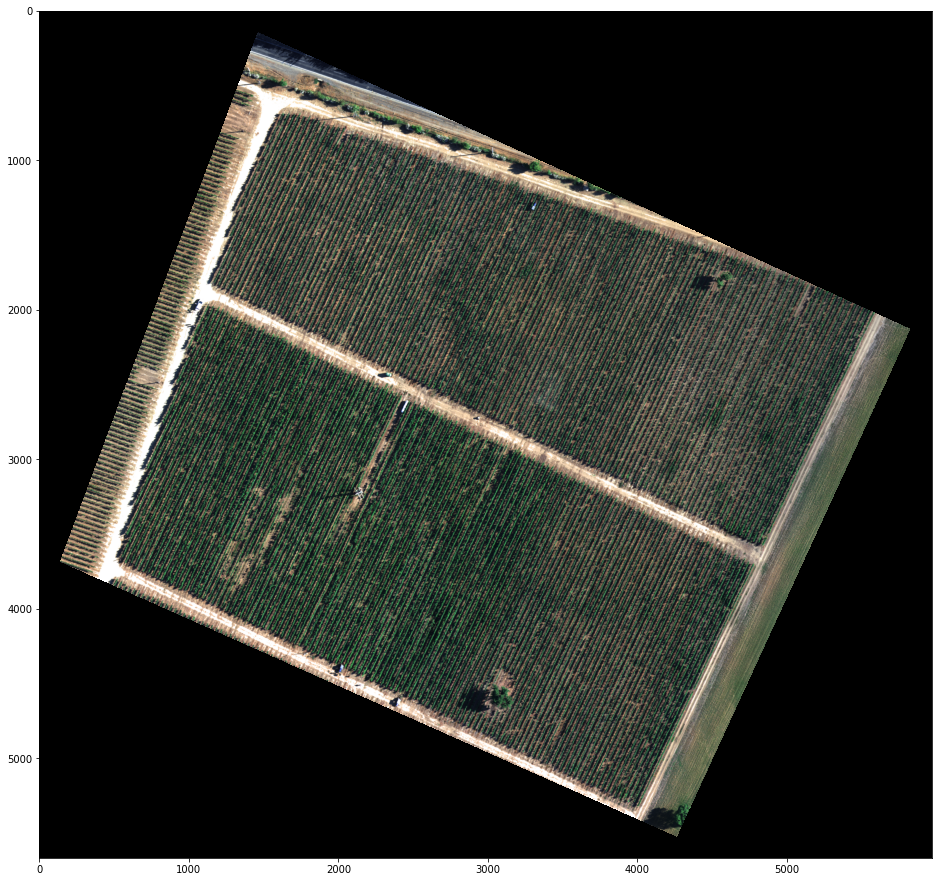

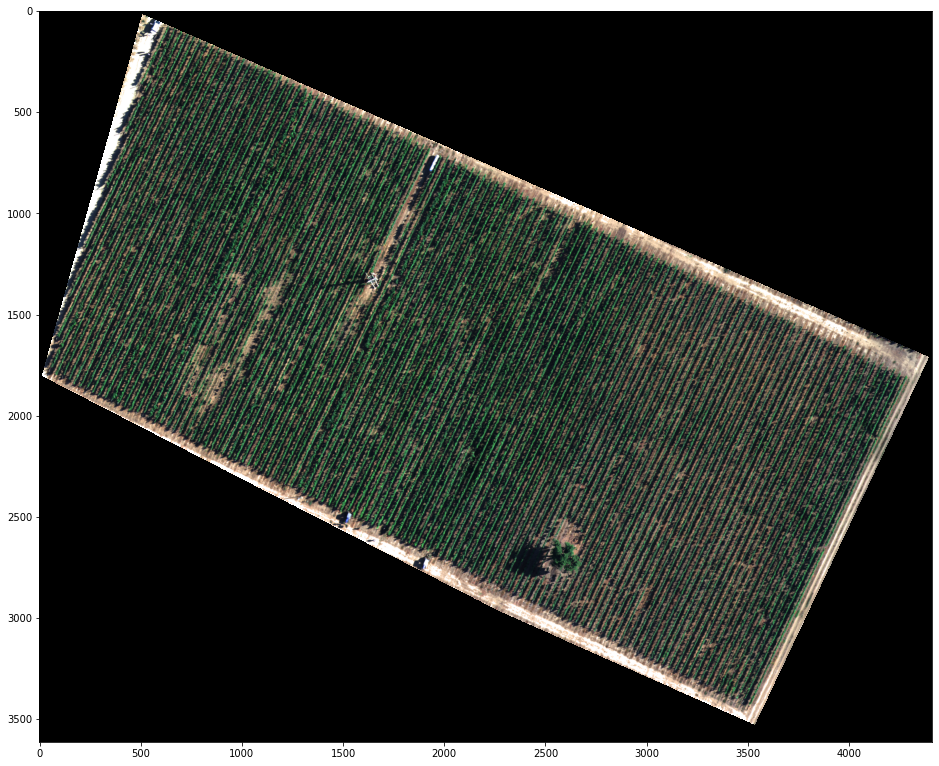

In [2]:
im_red_path = "Barrack A/result_Red.tif"
im_green_path = "Barrack A//result_Green.tif"
im_blue_path = "Barrack A/result_Blue.tif"
im_nir_path = "Barrack A/result_NIR.tif"
im_rededge_path = "Barrack A/result_RedEdge.tif"

im_multi = Image_Multi(im_red_path, im_green_path, im_blue_path, im_nir_path, im_rededge_path)

#List_P = [(1600, 500),(4800, 3600), (1100, 1900), (5500, 1900)]
List_P = [(500, 3700), (1000, 1900), (4900, 3600), (4000, 5500)]

im_multi_seg = im_multi.Segmentation(List_P)

Points = np.array(im_multi_seg.list_P)
Points_order = Utils.order_points_rect(Points)

M, maxWidth, maxHeight = Utils.perspectiveTransform(Points)

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(im_multi.RGB().raster)

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(im_multi_seg.RGB().raster)
print(im_multi_seg.list_P)


20
0.16580627876292442
0.15271631173507338
0.13089969572088256
0.122173048097727
0.10471975657670618
0.08726646133039484
0.06981316980937402
0.05235987828835298
0.030543261774701236
0.017453292452343616
0.16580627876292442
0.15271631173507338
0.13962633961874804
0.122173048097727
0.10471975657670618
0.08726646133039484
0.06981316980937402
0.05235987828835298
0.030543261774701236
0.017453292452343616


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


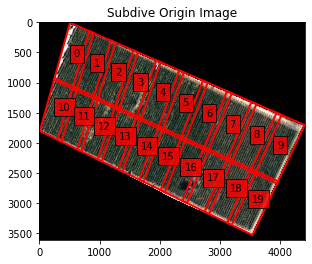

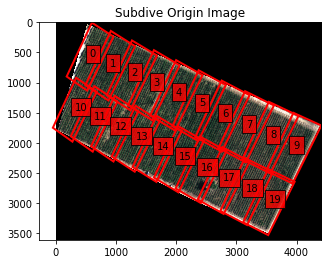

In [3]:
# top-left, top-right, bottom-right, and bottom-left
split_Weight, split_Height = 10, 2
sub_division = Utils.subdivision_rect([split_Weight, split_Height], maxWidth, maxHeight, 0.01)

sub_division_origin = cv2.perspectiveTransform(np.array(sub_division), np.linalg.inv(M))
print(len(sub_division))

List_P = np.uint(sub_division_origin)
List_new_P = []

for P in List_P:
    #P = List_P[3]
    im = im_multi_seg.Segmentation(P) 
    NDVI = im.NDVI().raster

    #NDVI = 2. * (NDVI - np.nanmin(NDVI)) / (np.nanmax(NDVI) - np.nanmin(NDVI))- 1
    #blur[np.isnan(blur)] = 0
    Points = np.array(im.list_P)

    M, maxWidth, maxHeight = Utils.perspectiveTransform(Utils.order_points_rect(Points))

    warped = cv2.warpPerspective(NDVI, M, (maxWidth, maxHeight))
    warped[np.isnan(warped)] = 0

    # Otsu
    blur = cv2.GaussianBlur(warped * 255,(5,5),0).astype('uint8')
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    n_important = 100
    skel_filter = Utils.skeleton(th3, n_important = 100)

    theta_prop = Utils.angle_lines(skel_filter,  n_important = 100, angle_resolution = 720,
                                   threshold = 100, min_line_length = 200,
                                   max_line_gap = 50, plot = False)


    #center = (im.list_P[0][0], im.list_P[0][1])
    #center_pol = center
    center = (np.mean([point[0] for point in P]), np.mean([point[1] for point in P]))
    matrix = cv2.getRotationMatrix2D(center=center, angle= -theta_prop*180/np.pi, scale=1)
    
    
    
    new_P = cv2.transform(np.array([P]), matrix)[0]

    #im_multi_seg_new = im_multi_seg.Segmentation(new_P)

    #new_Points = np.array(im_multi_seg_new.list_P)
    List_new_P.append(new_P)
    print(theta_prop)
    
plt.figure(0)
plt.imshow(im_multi_seg.RGB().raster)
plt.title('Subdive Origin Image')
ax = plt.gca()

for i,Poly in enumerate(List_P):
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)
    
    
plt.figure(1)
plt.imshow(im_multi_seg.RGB().raster)
plt.title('Subdive Origin Image')
ax = plt.gca()

ax.scatter(center[0], center[1], marker='o', color='g', label='point')
for i,Poly in enumerate(List_new_P):
    
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


Text(0.5, 1.0, 'NDVI > 0.6')

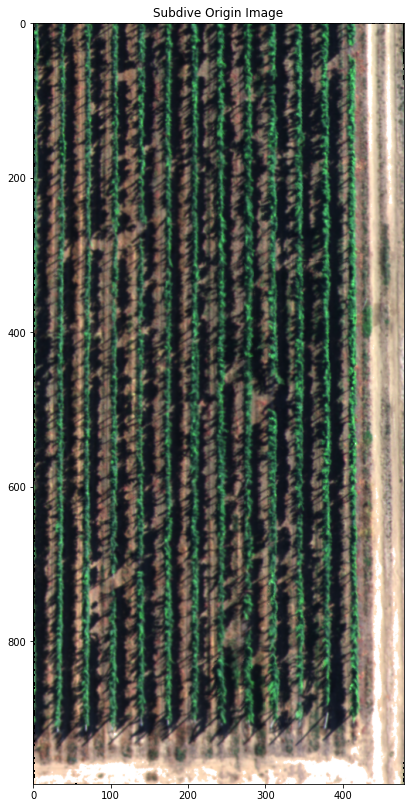

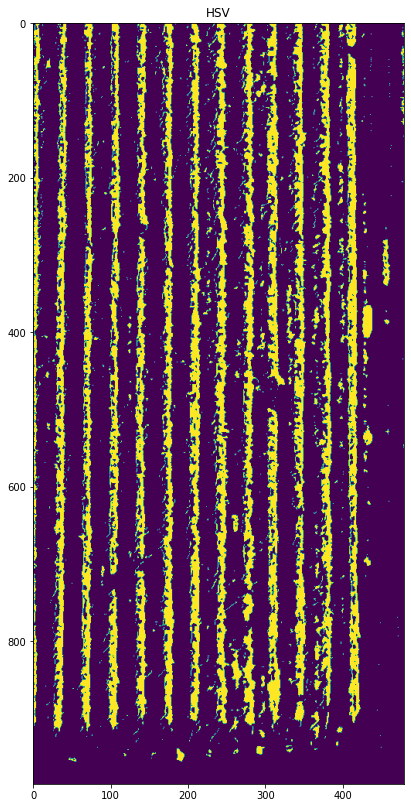

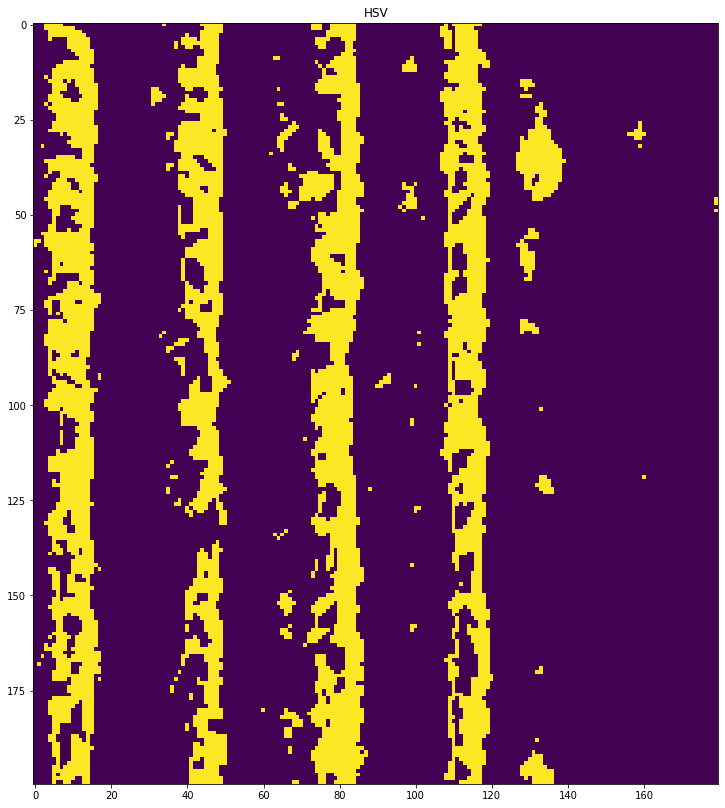

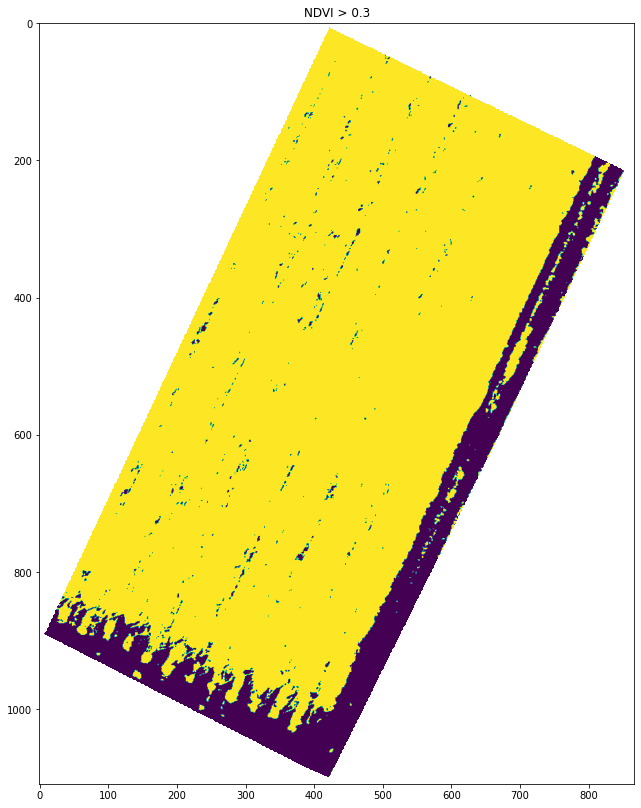

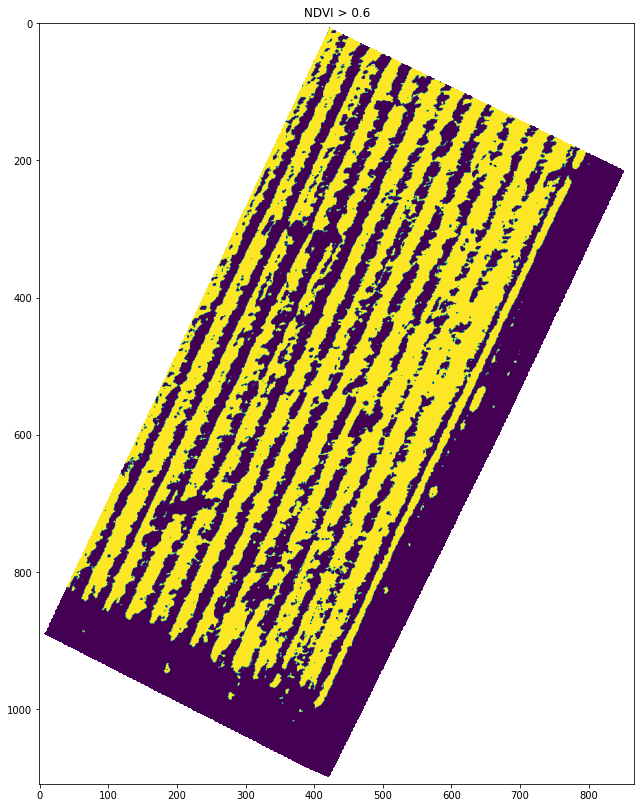

In [92]:
P = List_new_P[19]
P = Utils.order_points_rect(P)
im = im_multi_seg.Segmentation(P)

Points = np.array(im.list_P)
M, maxWidth, maxHeight = Utils.perspectiveTransform(Utils.order_points_rect(Points))
RGB = cv2.warpPerspective( im.RGB().raster, M, (maxWidth, maxHeight))

HSV = Utils.rgb2hsv(RGB)
H = HSV[:, :, 0]
H2 = H.copy()
H2 = cv2.GaussianBlur(H2,(9,9),0).astype('float32')
H2[H > 160] = 0
H2[H < 160] = 1
H2[H < 80] = 0
H2 = H2.astype('uint8')
#H2[np.isnan(H)] = np.nan

plt.figure(0, figsize = (14,14))
plt.imshow(RGB)
plt.title('Subdive Origin Image')


plt.figure(1, figsize = (14,14))
plt.imshow(H2)
plt.title('HSV')


plt.figure(2, figsize = (14,14))
plt.imshow(H2[500:700, 300:500])
plt.title('HSV')

plt.figure(3, figsize = (14,14))
plt.imshow(im.NDVI().raster > 0.3)
plt.title('NDVI > 0.3')

plt.figure(4, figsize = (14,14))
plt.imshow(im.NDVI().raster > 0.6)
plt.title('NDVI > 0.6')

Text(0.5, 1.0, 'dilate')

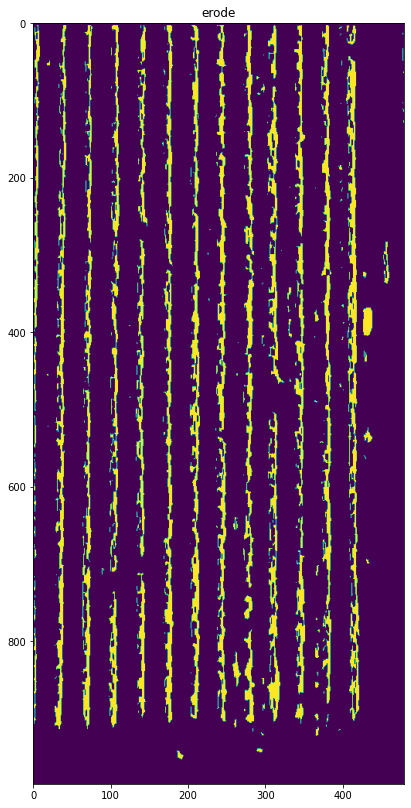

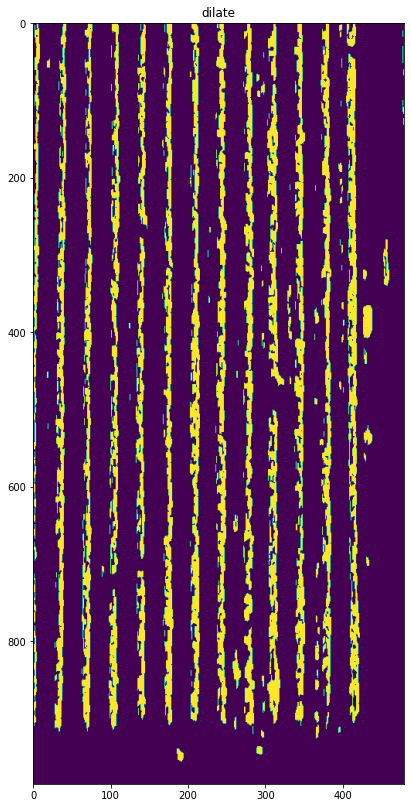

In [93]:
### Create kernel rotate #########333
size_kernel = 7
kernel = np.ones((size_kernel, 1) , np.uint8)  # note this is a vertical kernel

e_im = cv2.erode(H2, kernel, iterations=1) 
for i in range(100):
    
    
    d_im = cv2.dilate(e_im, kernel, iterations=1)
    e_im = cv2.erode(d_im, kernel, iterations=1) 

d_im = cv2.dilate(e_im, kernel, iterations=1)
   
plt.figure(1, figsize = (14,14))
plt.imshow(e_im)
plt.title('erode')
    
plt.figure(2, figsize = (14,14))
plt.imshow(d_im)
plt.title('dilate')





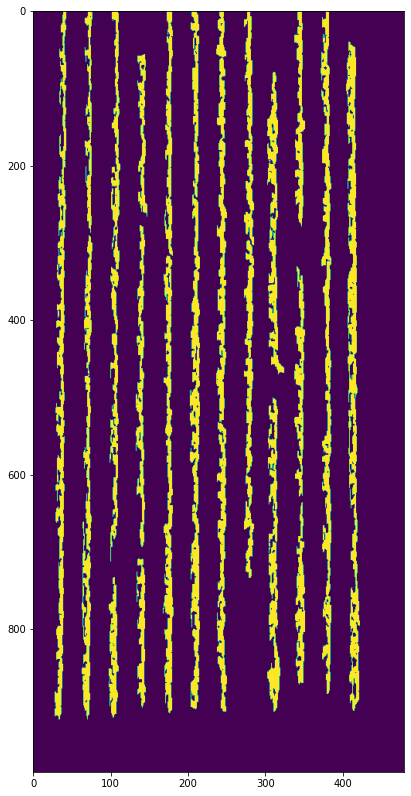

In [94]:
label_im, nb_labels = ndimage.label(d_im)#, structure= np.ones((2,2))) ## Label each connect region
label_areas = np.bincount(label_im.ravel())[1:]

th = 1000
#keys_max_areas = np.array(sorted(range(len(label_areas)), key=lambda k: label_areas[k], reverse = True)) + 1
#K = keys_max_areas[label_areas > th]
#keys_max_areas = keys_max_areas[:n_important]
L = np.zeros(label_im.shape)

List_Centroid_WH = []
for i in range(1, nb_labels):
    if label_areas[i] > th:
        L[label_im == (i + 1) ] = 1
        I = np.zeros(label_im.shape)
        I[label_im == (i + 1)] = 1
        # calculate moments of binary image
        M = cv2.moments(I)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cnts, hierarchy = cv2.findContours(I.astype('uint8'), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        width = np.max([x[0][0] for x in cnts[0]]) - np.min([x[0][0] for x in cnts[0]])
        height = np.max([y[0][1] for y in cnts[0]]) - np.min([y[0][1] for y in cnts[0]])
        List_Centroid_WH.append((cX, cY, width, height))
        

    


        
plt.figure(0, figsize = (14,14))
plt.imshow(L)


In [95]:
x_min = np.min([x[0] - x[2]/2 for x in List_Centroid_WH])
x_max = np.max([x[0] + x[2]/2 for x in List_Centroid_WH])
y_min = np.min([y[1] - y[3]/2 for y in List_Centroid_WH])
y_max = np.max([y[1] + y[3]/2 for y in List_Centroid_WH])
#avg_width = np.mean([x[2] for x in List_Centroid_WH]).astype('int')

### Agregate Epsilon

#avg_width += 5

L_xw = sorted([[x[0],x[2]] for x in List_Centroid_WH]) # x and width


aux = np.inf
th = 5
L_filter = [L_xw[0][0]]
L_width = [L_xw[0][1]]
for i in range(1, len(L_xw)):
    if (abs(L_filter[-1] - L_xw[i][0]) > th):
        L_filter.append(L_xw[i][0])
        L_width.append(L_xw[i][1])
        
dif = np.median(([L_filter[i] - L_filter[i-1] for i in range(1, len(L_filter))])).astype('int')


####################### lista de poligonos ################
List_lines = [] #(top-left, top-right,bottom-right, bottom-left

for i in range(len(L_filter)):
    
    avg_width = L_width[i]
    top_left = (int(L_filter[i] - avg_width/2) , y_min)
    top_right = (int(L_filter[i] + avg_width/2) , y_min)
    bottom_right = (int(L_filter[i] + avg_width/2) , y_max)
    bottom_left = (int(L_filter[i] - avg_width/2) , y_max)
    if  int(L_filter[i] - avg_width/2) > L.shape[1]:
        break
    
    List_lines.append((top_left, top_right, bottom_right, bottom_left))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


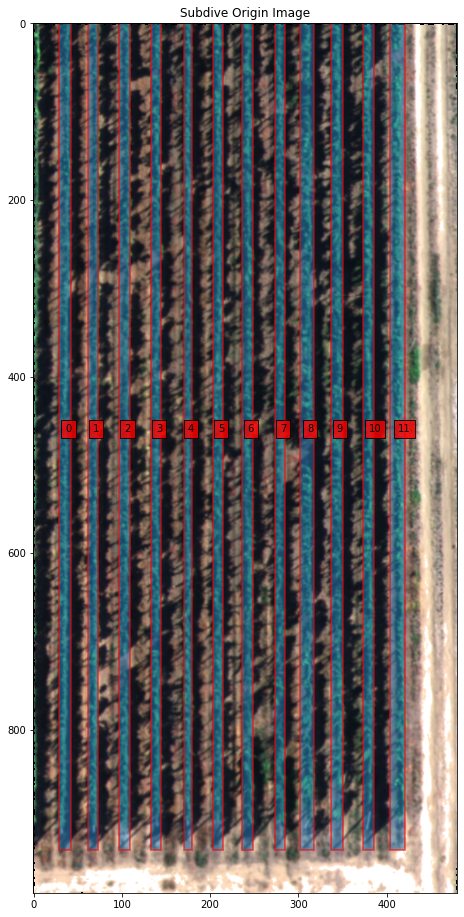

In [96]:
plt.figure(0, figsize = (16,16))
plt.imshow(RGB)
plt.title('Subdive Origin Image')
ax = plt.gca()

for i,Poly in enumerate(List_lines):
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     alpha=0.5,
                     fill = True)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)

In [70]:
L_x,i = sorted([x[0] for x in List_Centroid_WH])
# find the contours in the mask



ValueError: too many values to unpack (expected 2)

In [58]:
avg_width

53

In [59]:
np.median([L_filter[i] - L_filter[i-1] for i in range(1, len(L_filter))])

34.0

In [76]:
L_filter

[33, 88, 127, 146, 195, 231, 266, 299, 335, 368, 405, 438, 471, 504]

In [66]:
L_x

[33,
 88,
 127,
 130,
 146,
 195,
 197,
 231,
 266,
 299,
 335,
 368,
 368,
 405,
 438,
 471,
 504]

In [ ]:
Points_order

In [77]:
L_width

[70, 37, 15, 67, 39, 36, 33, 33, 24, 24, 37, 36, 35, 22]